# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\hp\Desktop\AppliedAI\ipython notes\database.sqlite\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
import datetime
final['Time']=pd.to_datetime(final['Time'], unit='s')
final=final.sort_values(by='Time')

In [11]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,2000-06-23,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [12]:
final.dtypes

Id                                 int64
ProductId                         object
UserId                            object
ProfileName                       object
HelpfulnessNumerator               int64
HelpfulnessDenominator             int64
Score                              int64
Time                      datetime64[ns]
Summary                           object
Text                              object
dtype: object

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

(87773, 10)
1    73592
0    14181
Name: Score, dtype: int64


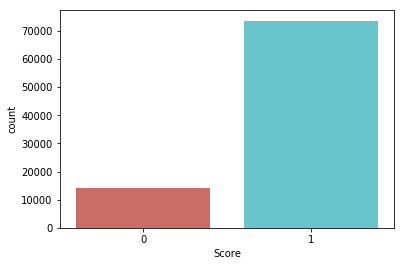

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
print(final['Score'].value_counts())

import seaborn as sns
sns.countplot(x='Score',data=final,palette='hls')
plt.show()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be ha

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
we use this as the base, then besides the chicken, we will also add pasta, spices, veggies, or whatever we have around to make quick cheesy meals
My dogs just love this food. The service is always fast and reliable.
I am amazed by how well this tea works to relieve my chronic congestion and recurring sinus problems. And it's not just a "quick" fix either -- its therapeutic effects last for hours. I was a bit worried the tea would be a bit too "licorice-y" since one of its main ingredients is licorice root, but the fragrance and taste are mild and incredibly soothing. If you think this package of six boxes is too much, you'll be happily prov

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My dogs just love this food. The service is always fast and reliable.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My dogs just love this food The service is always fast and reliable 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:06<00:00, 1316.45it/s]


In [26]:
preprocessed_reviews[1500]

'dogs love food service always fast reliable'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [27]:
con=sqlite3.connect(r'C:\Users\hp\Desktop\AppliedAI\ipython notes\database.sqlite\database.sqlite')
#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con)
df=pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3 LIMIT 100000''',con)
score_column=df['Score']
changed_score=score_column.map(partition)
df['Score']=changed_score
#df.head()
dis=pd.read_sql_query('SELECT ProductId,UserID,ProfileName,Score,Time,Summary,COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1',con)
#dis.head()
sorted_df=df.sort_values('ProductId', axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
f=sorted_df.drop_duplicates(subset={'UserId','ProfileName','Time','Summary'},keep='first', inplace=False)
f=f[f.HelpfulnessNumerator<=f.HelpfulnessDenominator]


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

from bs4 import BeautifulSoup
    
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(f['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

 37%|███████████████████████████▌                                              | 32654/87696 [00:15<00:27, 2034.69it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▊                      | 61400/87696 [00:29<00:12, 2126.58it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 75%|███████████████████████████████████████████████████████▎                  | 65553/87696 [00:31<00:10, 2122.28it/s]C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Bea

In [28]:
len(preprocessed_summaries)

87696

# [4] Featurization

## [4.1] BAG OF WORDS

In [29]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [30]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [31]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews[:30000]:
    list_of_sentance.append(sentance.split())

print(len(list_of_sentance))

30000


In [33]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

C:\Users\hp\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('fantastic', 0.8546158671379089), ('awesome', 0.801295280456543), ('good', 0.8011556267738342), ('excellent', 0.795674741268158), ('terrific', 0.7948061227798462), ('wonderful', 0.7836210131645203), ('amazing', 0.7688255310058594), ('perfect', 0.7407320141792297), ('decent', 0.7028741836547852), ('yummy', 0.6781202554702759)]
[('best', 0.7754102349281311), ('tastiest', 0.7684305310249329), ('greatest', 0.7401251792907715), ('compares', 0.7000561952590942), ('softest', 0.6960343718528748), ('tasted', 0.6852792501449585), ('closest', 0.6780439019203186), ('maraschino', 0.6748254299163818), ('richest', 0.6721289753913879), ('encountered', 0.6657102108001709)]


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10391
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:19<00:00, 214.85it/s]


30000
50


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews[:30000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [28:58<00:00, 12.16it/s]


30000
50


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [29]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

from sklearn.feature_extraction.text import CountVectorizer
count_vect=CountVectorizer() #initiating the bag of words library using countvectorizer.
#machine is reading all the words as we gave access to only training text data.
count_vect.fit(x_train)

#countvectorizer is transforming the read text data into vectors.
x_trn_bow=count_vect.transform(x_train)
x_tst_bow=count_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_bow=stand.fit_transform(x_trn_bow)
x_tst_bow=stand.transform(x_tst_bow)

In [30]:
x_trn_bow.shape,x_tst_bow.shape

((61441, 45800), (26332, 45800))

In [31]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
#import math
model=DecisionTreeClassifier(class_weight='balanced')
parameters={'max_depth' :[1, 5, 10, 50, 100, 500, 1000],
            'min_samples_split' :[5, 10, 100, 500]}
clf=RandomizedSearchCV(model,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf=clf.fit(x_trn_bow,y_train)

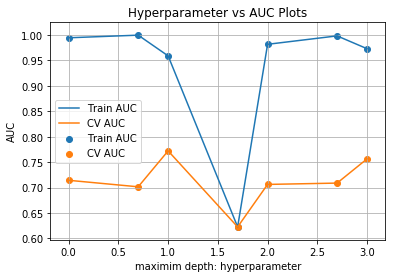

In [32]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

K=np.log10([1, 5, 10, 50, 100, 500, 1000])
plt.plot(K, train_auc[:7], label='Train AUC')
plt.scatter(K,train_auc[:7],label='Train AUC')

plt.plot(K, cv_auc[:7], label='CV AUC')
plt.scatter(K,cv_auc[:7],label='CV AUC')

plt.legend()
plt.xlabel("maximim depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter vs AUC Plots")
plt.grid()
plt.show()

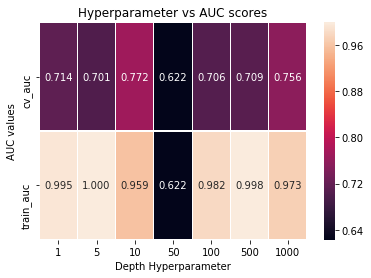

In [33]:
frame=pd.DataFrame(train_auc[:7],columns=['train_auc'])
frame['cv_auc']=cv_auc[:7]
frame['K']=[1, 5, 10, 50, 100, 500, 1000]
table=pd.pivot_table(frame,values=['train_auc','cv_auc'],columns=['K'])
import seaborn as sns
sns.heatmap(table, annot=True, fmt=".3f" ,linewidths=.2)
plt.title('Hyperparameter vs AUC scores')
plt.xlabel('Depth Hyperparameter')
plt.ylabel('AUC values')
plt.show()

In [34]:
best_c=clf.best_params_['max_depth']
best_reg=clf.best_params_['min_samples_split']
print(best_c)
print(best_reg)

50
500


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8187174210806913


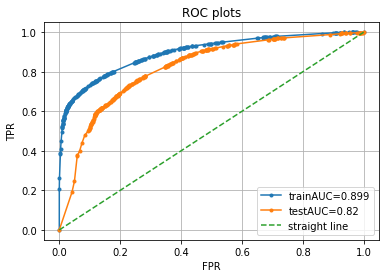

In [35]:
from sklearn.tree import DecisionTreeClassifier
modell = DecisionTreeClassifier(max_depth=best_c,min_samples_split=best_reg,class_weight='balanced')
modell.fit(x_trn_bow, y_train)
y_trn_pred=modell.predict(x_trn_bow)
y_tst_pred= modell.predict(x_tst_bow)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probs=modell.predict_proba(x_trn_bow)[:,1]
x_tst_probs=modell.predict_proba(x_tst_bow)[:,1]
print(clf.best_estimator_)
print(clf.score(x_tst_bow, y_test))
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probs)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probs)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

In [36]:
def find_best_threshold(Threshold, fpr, tpr):
    t = Threshold[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr):", max(tpr*(1-fpr)), "------> for Threshold:", np.round(t,3))
    return t

def predict_with_best_t(proba, Threshold):
    predictions = []
    for i in proba:
        if i>=Threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr): 0.6636265625864437 ------> for Threshold: 0.474
confusion matrix using train data:
[[ 8488  1132]
 [12908 38913]]


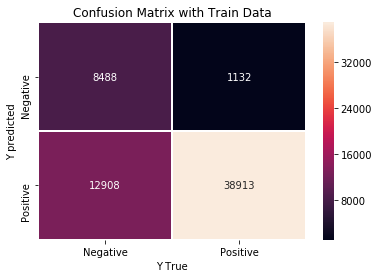

In [37]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

r=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(r, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3523  1038]
 [ 5939 15832]]


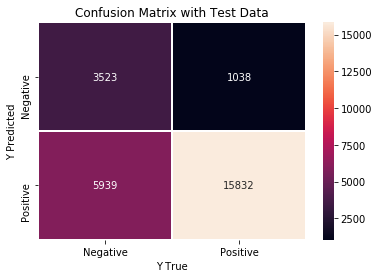

In [38]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
e=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(e, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y True')
plt.ylabel('Y Predicted')
plt.show()

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [39]:
#sparcity
np.count_nonzero(modell.feature_importances_)

514

In [40]:
# the below argsort gives the sorted feature_importance indices as output.
prob_sorted_indicess = modell.feature_importances_.argsort()
#now getting the features_names as with those top 10 sorted indices.
TOP20_features=np.take(count_vect.get_feature_names(), prob_sorted_indicess[-20:])
pd.DataFrame(TOP20_features,columns=['Top20_features'])

,Top20_features
0,tasty
1,worst
2,easy
3,product
4,thought
5,money
6,wonderful
7,disappointed
8,favorite
9,excellent


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [41]:
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [42]:
features=count_vect.get_feature_names()

import io
from sklearn.tree import export_graphviz
import pydotplus
from scipy import misc

### Method 1

In [43]:
def show_tree(tree, features, path):
    f=io.StringIO()
    export_graphviz(modell,out_file=f,feature_names=features,max_depth=3)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    image=misc.imread(path)
    plt.rcParams['figure.figsize']=(20,20)
    plt.imshow(image)

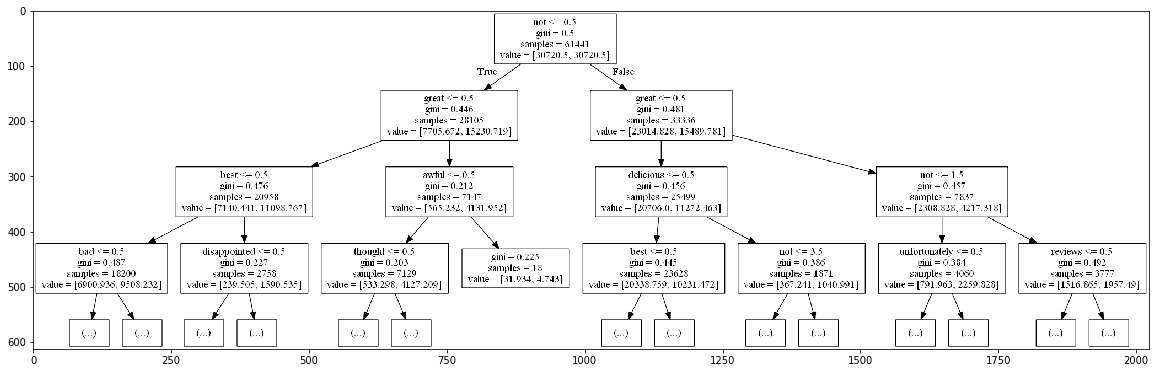

In [44]:
show_tree(modell,features,'DecisionTree_BOW.png')

### Method 2

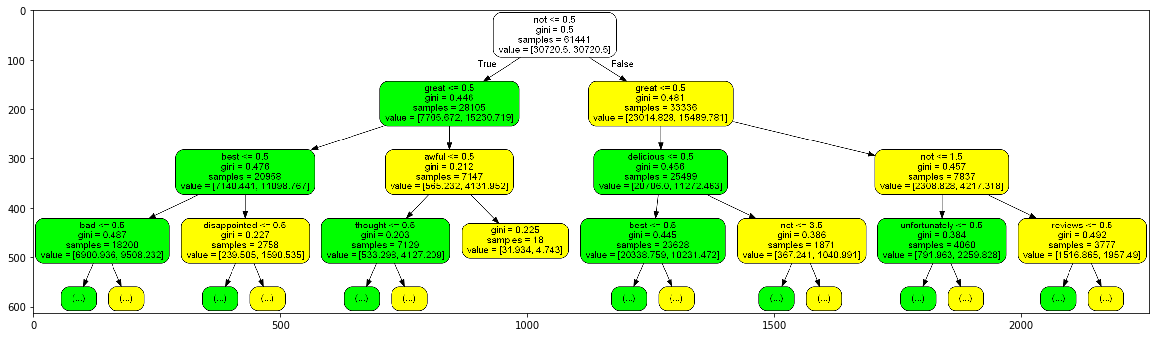

In [45]:
import collections
dot_data = export_graphviz(modell,out_file=None,feature_names=features,max_depth=3,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('green', 'yellow')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('Dtree_BOW.png')
image=misc.imread('Dtree_BOW.png')
plt.rcParams['figure.figsize']=(20,20)
plt.imshow(image)
plt.show()

I have used following links to get above code.
 * https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not/56428#56428?s=75903b27e82649d4be31408dc0a2203d
 * https://pythonprogramminglanguage.com/decision-tree-visual-example/
 * https://www.youtube.com/watch?v=XDbj6PxaSf0
 * http://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3078/assignment-8-apply-decision-trees/4/module-4-machine-learning-ii-supervised-learning-models#comment70810

## Feature Engineering

In [46]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

In [47]:
review_count=list()
for i in preprocessed_reviews:
    review_count.append(len(i.split()))

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
vect=CountVectorizer() #initiating the bag of words library using countvectorizer.
#machine is reading all the words as we gave access to only training text data.
vect.fit(x_train)

#countvectorizer is transforming the read text data into vectors.
x_trn_bows=vect.transform(x_train)
x_tst_bows=vect.transform(x_test[:26255])
xsumm_trn_bows=vect.transform(preprocessed_summaries[:61441])
xsumm_tst_bows=vect.transform(preprocessed_summaries[61441:])

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_bows=stand.fit_transform(x_trn_bows)
x_tst_bows=stand.fit_transform(x_tst_bows)
xsumm_trn_bows=stand.fit_transform(xsumm_trn_bows)
xsumm_tst_bows=stand.transform(xsumm_tst_bows)

In [49]:
x_trn_bows.shape,x_tst_bows.shape,xsumm_tst_bows.shape,xsumm_trn_bows.shape

((61441, 45800), (26255, 45800), (26255, 45800), (61441, 45800))

In [50]:
from scipy.sparse import csr_matrix,hstack
s=csr_matrix((review_count[:61441]),dtype=np.int64).T
d=csr_matrix((review_count[61441:]),dtype=np.int64).T
d=d[:26255]

x_tr=hstack([x_trn_bows,s,xsumm_trn_bows])
x_ts=hstack([x_tst_bows,d,xsumm_tst_bows])

In [51]:
x_tr.shape,x_ts.shape

((61441, 91601), (26255, 91601))

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
models=DecisionTreeClassifier(class_weight='balanced')
parameters={'max_depth' :[1, 5, 10, 50, 100, 500, 1000],
            'min_samples_split' :[5, 10, 100, 500]}
clfs=RandomizedSearchCV(models,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clfs=clfs.fit(x_tr,y_train)

In [53]:
plt.rcParams['figure.figsize']=(10,10)

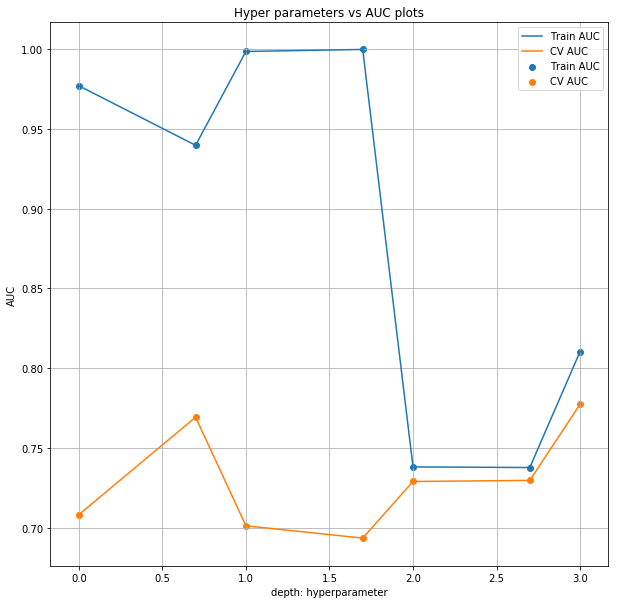

In [54]:
train_auc= clfs.cv_results_['mean_train_score']
train_auc_std= clfs.cv_results_['std_train_score']
cv_auc = clfs.cv_results_['mean_test_score'] 
cv_auc_std= clfs.cv_results_['std_test_score']

K=np.log10([1, 5, 10, 50, 100, 500, 1000])
plt.plot(K, train_auc[:7], label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc[:7],label='Train AUC')

plt.plot(K, cv_auc[:7], label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc[:7],label='CV AUC')

plt.legend()
plt.xlabel("depth: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameters vs AUC plots")
plt.grid()
plt.show()

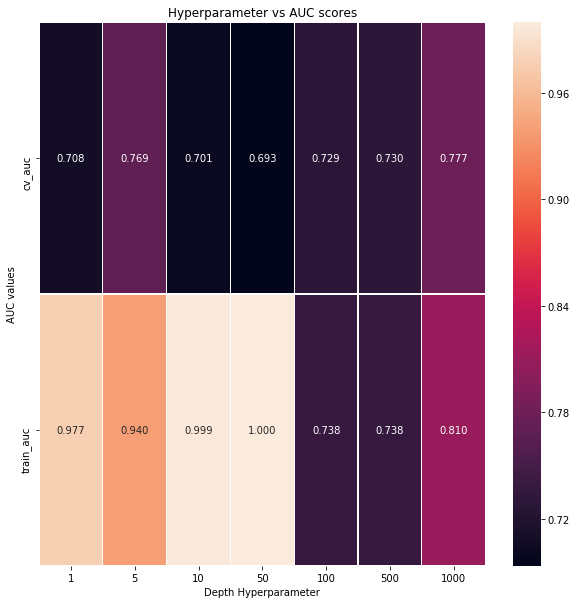

In [55]:
frame=pd.DataFrame(train_auc[:7],columns=['train_auc'])
frame['cv_auc']=cv_auc[:7]
frame['K']=[1, 5, 10, 50, 100, 500, 1000]
table=pd.pivot_table(frame,values=['train_auc','cv_auc'],columns=['K'])
import seaborn as sns
sns.heatmap(table, annot=True, fmt=".3f" ,linewidths=.2)
plt.title('Hyperparameter vs AUC scores')
plt.xlabel('Depth Hyperparameter')
plt.ylabel('AUC values')
plt.show()

In [56]:
best_cs=clfs.best_params_['max_depth']
best_regs=clfs.best_params_['min_samples_split']
print(best_cs)
print(best_regs)

50
500


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=50,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.8168728833939616


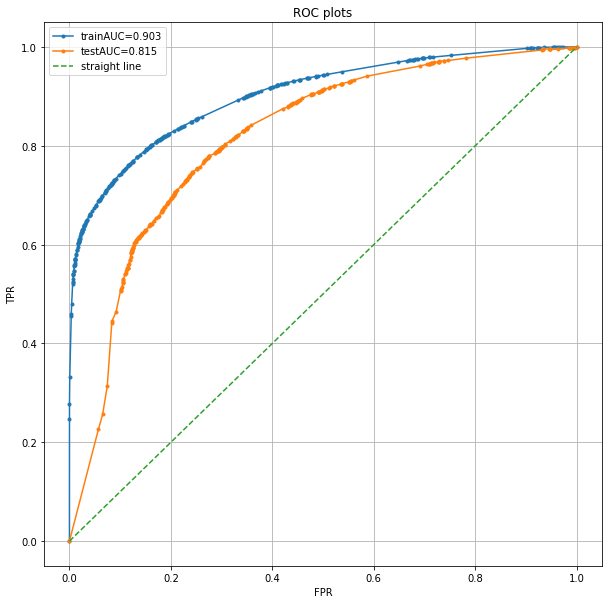

In [57]:
#Now testing with Test data.
from sklearn.tree import DecisionTreeClassifier
modelss = DecisionTreeClassifier(max_depth=best_cs,min_samples_split=best_regs,class_weight='balanced')
modelss.fit(x_tr, y_train)
y_trn_predS=modelss.predict(x_tr)
y_tst_predS= modelss.predict(x_ts)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probs=modelss.predict_proba(x_tr)[:,1]
x_tst_probs=modelss.predict_proba(x_ts)[:,1]
print(clfs.best_estimator_)
print(clfs.score(x_ts, y_test[:26255]))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probs)
test_fpr,test_tpr,thresholds=roc_curve(y_test[:26255],x_tst_probs)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.rcParams['figure.figsize']=(10,10)
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.6730430125675296 ------> for Threshold: 0.474
confusion matrix using train data:
[[ 8492  1128]
 [12378 39443]]


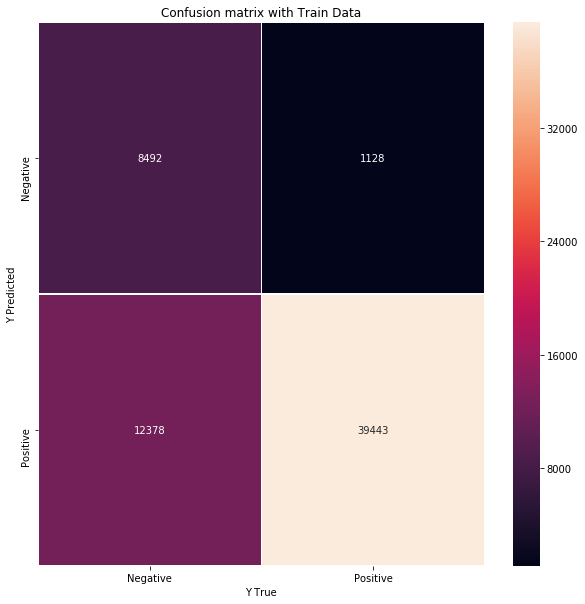

In [58]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_predS, best_t)))

a=confusion_matrix(y_train,predict_with_best_t(y_trn_predS, best_t))
import seaborn as sns
sns.heatmap(a, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y Predicted')
plt.show()

confusion matrix using test data:
[[ 3476  1074]
 [ 5666 16039]]


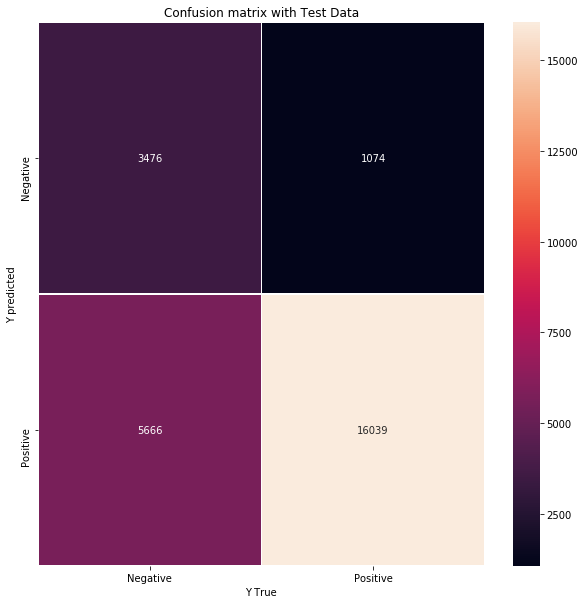

In [59]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test[:26255],predict_with_best_t(y_tst_predS, best_t)))
b=confusion_matrix(y_test[:26255],predict_with_best_t(y_tst_predS, best_t))
import seaborn as sns
sns.heatmap(b, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Test Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [60]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:61441]
x_test=preprocessed_reviews[61441:]
y_train=final['Score'][:61441]
y_test=final['Score'][61441:]

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect= TfidfVectorizer(ngram_range=(1,2),min_df=10) #initiating Tfidf
#machine is reading or learning all the text reviews from training data
tf_idf_vect.fit(x_train)

#Now transforming all the words learnt into vectors.
x_trn_tfidf=tf_idf_vect.transform(x_train)
x_tst_tfidf= tf_idf_vect.transform(x_test)

from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
x_trn_tfidf=stand.fit_transform(x_trn_tfidf)
x_tst_tfidf=stand.transform(x_tst_tfidf)

In [61]:
x_trn_tfidf.shape,x_tst_tfidf.shape

((61441, 36171), (26332, 36171))

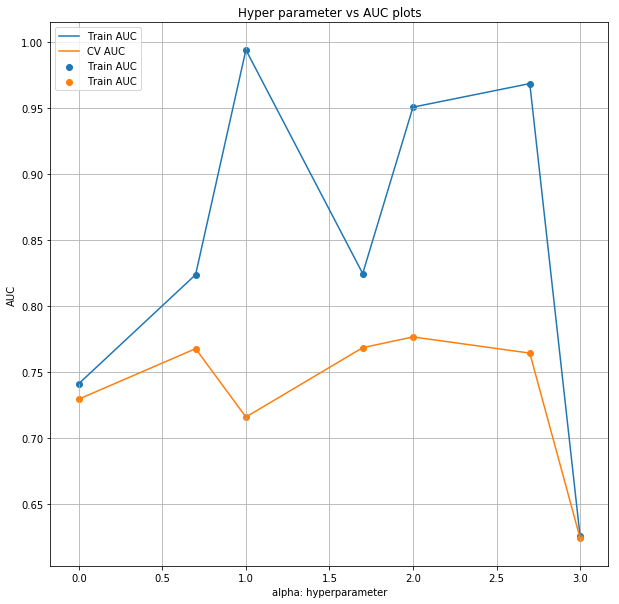

In [62]:
from sklearn.model_selection import RandomizedSearchCV

model2=DecisionTreeClassifier(class_weight='balanced')
parameters={'max_depth' :[1, 5, 10, 50, 100, 500, 1000],
            'min_samples_split' :[5, 10, 100, 500]}
clf2=RandomizedSearchCV(model2,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf2=clf2.fit(x_trn_tfidf,y_train)

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']

K=np.log10([1, 5, 10, 50, 100, 500, 1000])
plt.plot(K, train_auc[:7], label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc[:7],label='Train AUC')

plt.plot(K, cv_auc[:7], label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc[:7],label='Train AUC')

plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter vs AUC plots")
plt.rcParams['figure.figsize']=(10,10)
plt.grid()
plt.show()

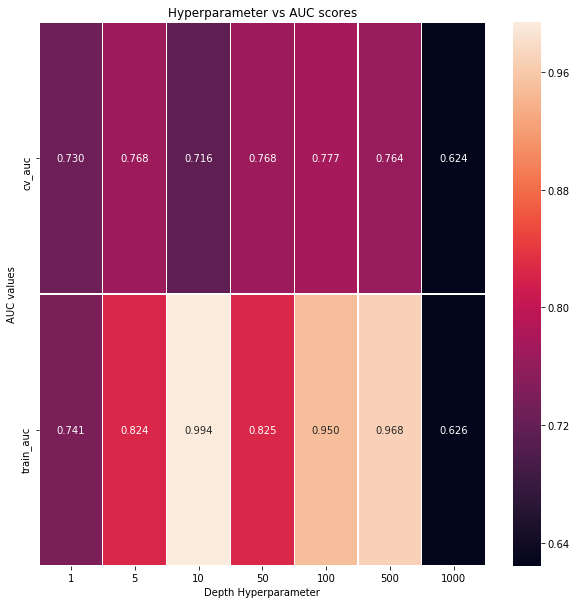

In [63]:
frame=pd.DataFrame(train_auc[:7],columns=['train_auc'])
frame['cv_auc']=cv_auc[:7]
frame['K']=[1, 5, 10, 50, 100, 500, 1000]
table=pd.pivot_table(frame,values=['train_auc','cv_auc'],columns=['K'])
import seaborn as sns
sns.heatmap(table, annot=True, fmt=".3f" ,linewidths=.2)
plt.title('Hyperparameter vs AUC scores')
plt.xlabel('Depth Hyperparameter')
plt.ylabel('AUC values')
plt.show()

In [64]:
best_alpha_tfidf=clf2.best_params_['max_depth']
best_reg_tfidf=clf2.best_params_['min_samples_split']
print(best_alpha_tfidf)
print(best_reg_tfidf)

1000
500


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7847717230753704


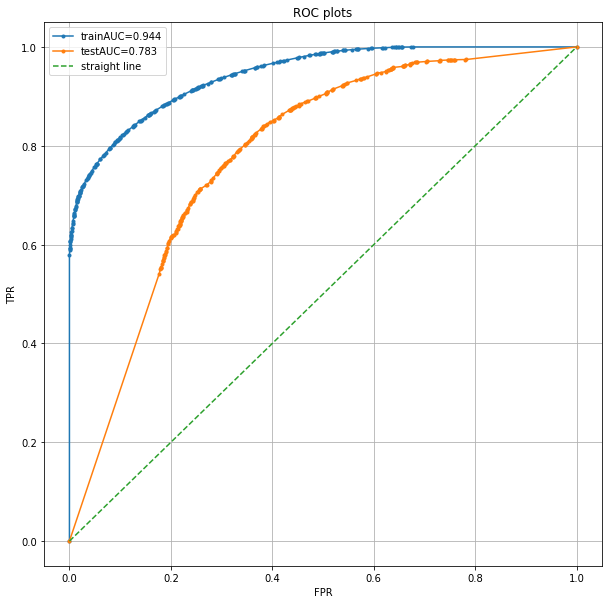

In [65]:
#Now testing with Test data.

model2s = DecisionTreeClassifier(max_depth=best_alpha_tfidf,min_samples_split=best_reg_tfidf,class_weight='balanced')
model2s.fit(x_trn_tfidf, y_train)
y_trn_predss=model2s.predict(x_trn_tfidf)
y_tst_predss= model2s.predict(x_tst_tfidf)

#(area under the curve)AUC= roc_auc_score(y_true, y_probs) the 2nd parameter should be probability estimates 
#  of the positive class not the predicted outputs.

x_trn_probss=model2s.predict_proba(x_trn_tfidf)[:,1]
x_tst_probss=model2s.predict_proba(x_tst_tfidf)[:,1]
print(clf2.best_estimator_)
print(clf2.score(x_tst_tfidf, y_test))
# Also we have direct library 'auc' to find the Area Under the ROC Curve. i have plotted in below graph.
from sklearn.metrics import roc_curve,auc
train_fpr,train_tpr,threshold=roc_curve(y_train,x_trn_probss)
test_fpr,test_tpr,thresholds=roc_curve(y_test,x_tst_probss)
plt.plot(train_fpr,train_tpr,marker='.',label='trainAUC='+str(np.round(auc(train_fpr,train_tpr),3)))
plt.plot(test_fpr,test_tpr,marker='.',label='testAUC='+str(np.round(auc(test_fpr,test_tpr),3)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.title('ROC plots')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.7351286479072512 ------> for Threshold: 0.481
confusion matrix using train data:
[[ 8681   939]
 [ 9623 42198]]


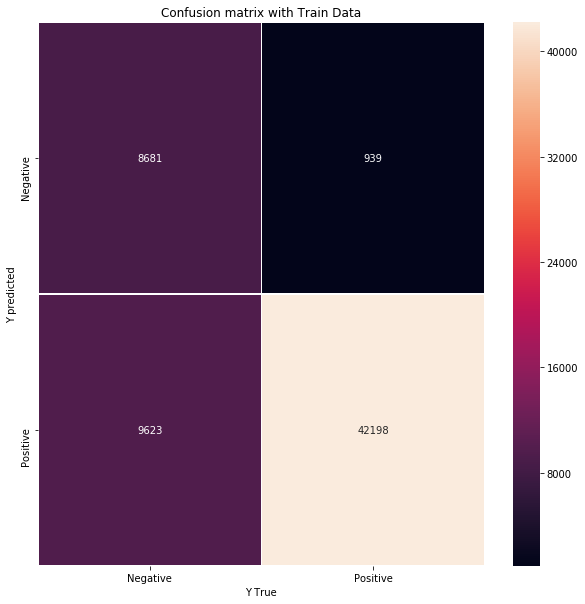

In [66]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_predss, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[ 3164  1397]
 [ 5169 16602]]


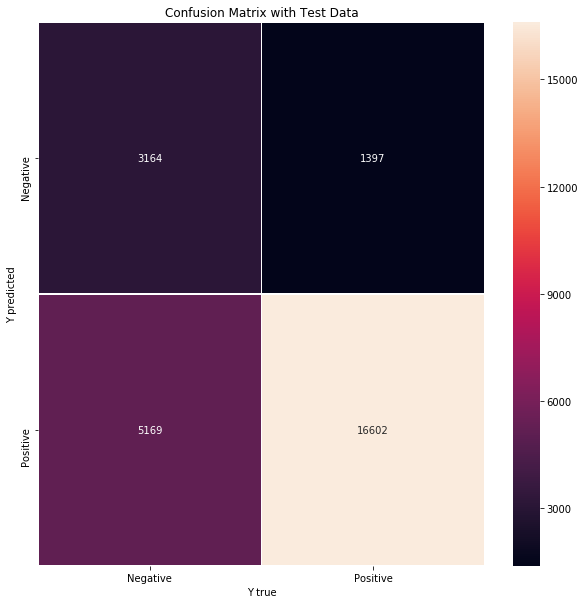

In [67]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_predss, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [68]:
# the below argsort gives the sorted feature_log _prob indices as output.
prob_sorted_indicess =model2s.feature_importances_.argsort()
#now getting the features_names as with those top 10 sorted indices.
TOP20_features=np.take(tf_idf_vect.get_feature_names(), prob_sorted_indicess[-20:])
pd.DataFrame(TOP20_features,columns=['Top20__features'])

,Top20__features
0,money
1,reviews
2,unfortunately
3,easy
4,product
5,thought
6,wonderful
7,excellent
8,favorite
9,nice


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

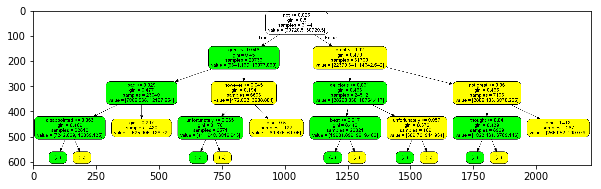

In [69]:
feat=tf_idf_vect.get_feature_names()
import collections
dot_data = export_graphviz(model2s,out_file=None,feature_names=feat,max_depth=3,filled=True,rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('green', 'yellow')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('Dtree_TFIDF.png')
image=misc.imread('Dtree_TFIDF.png')
plt.rcParams['figure.figsize']=(10,10)
plt.imshow(image)
plt.show()

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [70]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:21000]
x_test=preprocessed_reviews[21000:30000]
y_train=final['Score'][:21000]
y_test=final['Score'][21000:30000]

In [71]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

print(len(list_of_sentance_train))

21000


In [72]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

# this line of code trains your w2v model on the give list of sentances
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

C:\Users\hp\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [73]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  8707
sample words  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'love', 'call']


In [74]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(len(sent_vectors_train))
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 21000/21000 [00:51<00:00, 405.39it/s]


21000
[ 0.48270455  0.03167366  0.3897061  -0.22357353 -0.34208254  0.38635655
 -0.11391362  0.04894533 -0.35690144 -0.24971014 -0.23358595  0.28477054
 -0.46540992  0.00719832 -0.37873985 -0.11608094 -0.64287539  0.39467455
  0.06888901  0.07590439  0.15644369  0.02570935  0.07103328  0.00559979
  0.02758153 -0.26990007  0.18303318 -0.04036926  0.19385045  0.33129123
 -0.08320901  0.07492872 -0.04500405 -0.64133707  0.04746047 -0.2551785
  0.30660544 -0.02125607  0.12922958  0.21263006  0.38494178 -0.51254077
  0.139622    0.73184151  0.20408086 -0.28409697 -0.23194881 -0.43189751
  0.62939803 -0.37047857]


**Converting test text**

In [75]:
i=0
list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())
    
print(len(list_of_sentance_test))

9000


In [76]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(len(sent_vectors_test))
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:23<00:00, 381.79it/s]


9000
[ 5.04632786e-01 -2.16328835e-01  5.07691362e-01 -2.72432787e-01
 -6.78680381e-01  4.30172504e-01 -3.17450178e-02 -2.46819364e-02
 -2.98761972e-01 -2.47999181e-01 -2.05782863e-01  6.70849980e-01
 -1.32993666e-01 -2.08126097e-01 -1.63161187e-01 -3.39446661e-01
 -5.22888203e-01  2.79515358e-01  4.04942409e-01 -4.58340593e-02
  3.97197437e-01  2.54461730e-01 -4.26257160e-01 -7.78488715e-02
  1.83938330e-01 -3.74026375e-01 -1.81177692e-01 -2.89696145e-01
  2.84960602e-01  2.13456868e-01  9.02904403e-02  5.22982416e-03
 -4.53275615e-02 -4.12520414e-01  1.28439354e-01 -3.45867629e-01
  4.69085197e-01 -1.30778163e-04  2.87713152e-01  3.83575666e-01
  1.76351195e-01 -6.00873906e-01  1.41703937e-01  9.13579361e-01
  9.55960321e-03 -3.93568875e-01 -1.91209348e-01 -2.56161893e-01
  5.56596915e-01 -6.27229449e-01]


In [77]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
sent_vectors_train=stand.fit_transform(sent_vectors_train)
sent_vectors_test=stand.transform(sent_vectors_test)

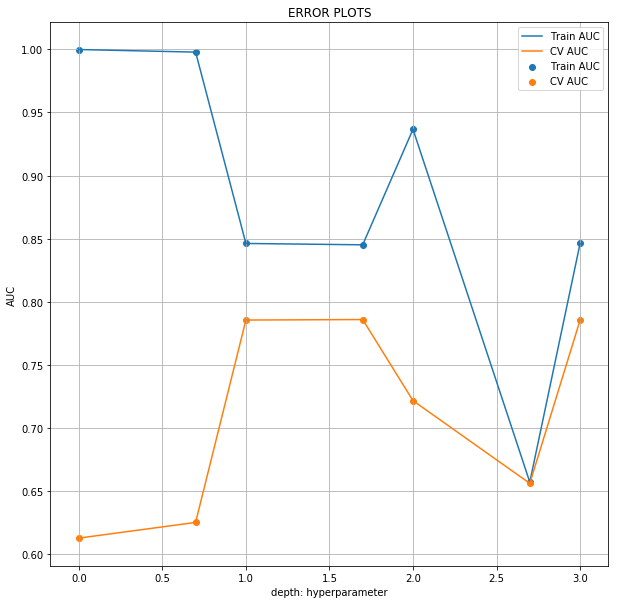

In [78]:
from sklearn.model_selection import RandomizedSearchCV

model4=DecisionTreeClassifier(class_weight='balanced')
parameters={'max_depth' :[1, 5, 10, 50, 100, 500, 1000],
            'min_samples_split' :[5, 10, 100, 500]}
clf4=RandomizedSearchCV(model4,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf4=clf4.fit(sent_vectors_train,y_train)

train_auc= clf4.cv_results_['mean_train_score']
train_auc_std= clf4.cv_results_['std_train_score']
cv_auc = clf4.cv_results_['mean_test_score'] 
cv_auc_std= clf4.cv_results_['std_test_score']

K=np.log10([1, 5, 10, 50, 100, 500, 1000])
plt.plot(K, train_auc[:7], label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc[:7],label='Train AUC')

plt.plot(K, cv_auc[:7], label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc[:7],label='CV AUC')

plt.legend()
plt.xlabel("depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.rcParams['figure.figsize']=(10,10)
plt.grid()
plt.show()

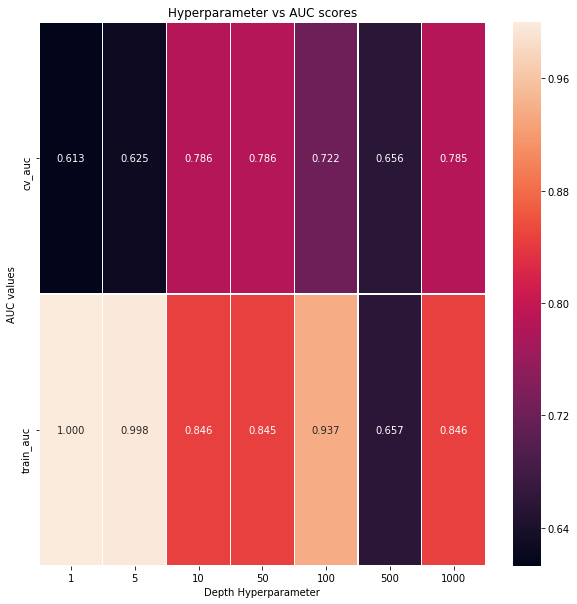

In [79]:
frame=pd.DataFrame(train_auc[:7],columns=['train_auc'])
frame['cv_auc']=cv_auc[:7]
frame['K']=[1, 5, 10, 50, 100, 500, 1000]
table=pd.pivot_table(frame,values=['train_auc','cv_auc'],columns=['K'])
import seaborn as sns
sns.heatmap(table, annot=True, fmt=".3f" ,linewidths=.2)
plt.title('Hyperparameter vs AUC scores')
plt.xlabel('Depth Hyperparameter')
plt.ylabel('AUC values')
plt.show()

In [80]:
bestC=clf4.best_params_['max_depth']
bestarg=clf4.best_params_['min_samples_split']
print(bestarg)
print(bestC)

500
10


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.7786689038991754


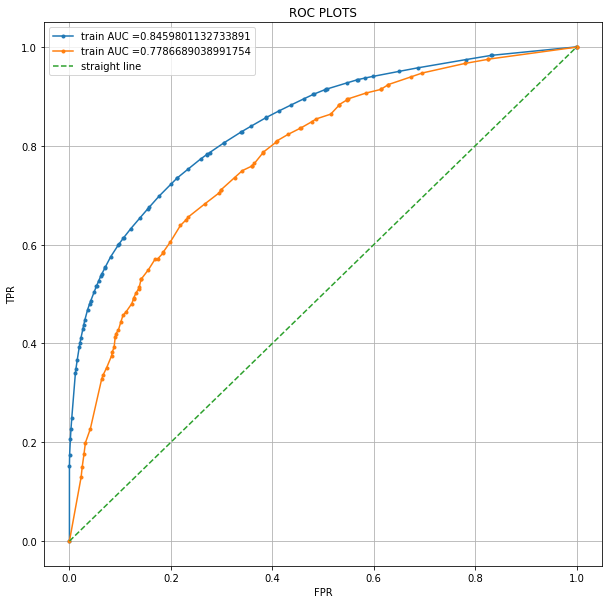

In [81]:
from sklearn.tree import DecisionTreeClassifier
model4s = DecisionTreeClassifier(max_depth=bestC,min_samples_split=bestarg,class_weight='balanced')
model4s.fit(sent_vectors_train, y_train)
y_trn_pred=model4s.predict(sent_vectors_train)
y_tst_pred=model4s.predict(sent_vectors_test)

print(clf4.best_estimator_)
print(clf4.score(sent_vectors_test, y_test))
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, threshold = roc_curve(y_train, model4s.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model4s.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.rcParams['figure.figsize']=(10,10)
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.5786693428612703 ------> for Threshold: 0.504
confusion matrix using train data:
[[ 2088   563]
 [ 4868 13481]]


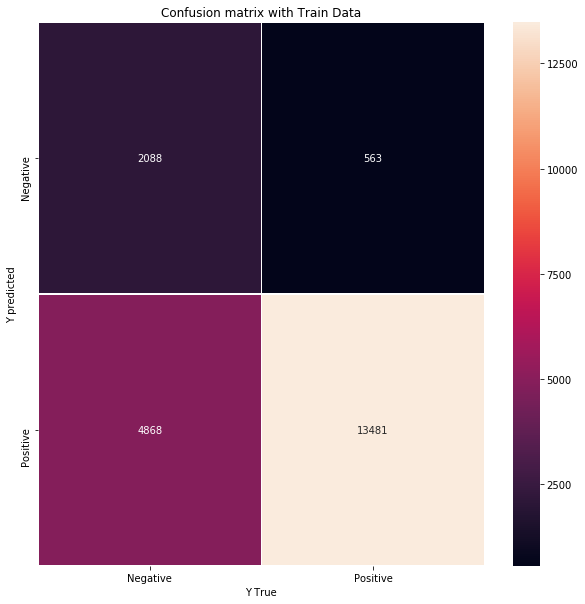

In [82]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1003  428]
 [2190 5379]]


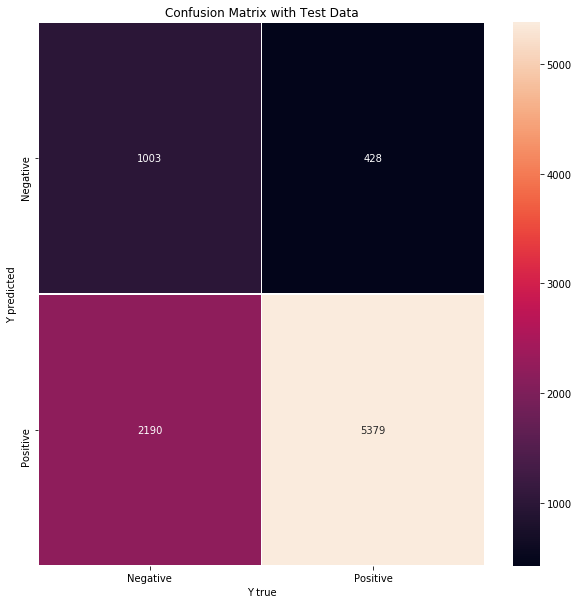

In [83]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [84]:
X=preprocessed_reviews
Y=final['Score']
x_train=preprocessed_reviews[:21000]
x_test=preprocessed_reviews[21000:30000]
y_train=final['Score'][:21000]
y_test=final['Score'][21000:30000]

In [85]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [86]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_train:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(tfidf_sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 21000/21000 [07:08<00:00, 49.05it/s]


21000
[ 4.32042237e-01 -9.03652924e-05  3.95652007e-01 -1.20603981e-01
 -3.14927863e-01  3.85438524e-01 -6.98956055e-02  2.62146995e-02
 -3.02826650e-01 -2.70162517e-01 -1.56272288e-01  3.59224375e-01
 -3.60398747e-01 -3.05587198e-02 -2.68234553e-01 -5.70861893e-02
 -5.55032098e-01  3.41615676e-01  5.62834826e-02  5.30696014e-02
  8.40578064e-02  5.73606530e-02  6.69064862e-02 -1.88058628e-02
 -1.25426846e-02 -2.92702283e-01  8.00748583e-02 -2.87060629e-02
  1.91743651e-01  2.84129353e-01  3.15579464e-03  5.55021102e-02
 -4.16204497e-03 -5.34454293e-01  4.45889286e-02 -2.01187017e-01
  2.50801641e-01 -1.02105368e-02  1.72015004e-01  2.13758908e-01
  1.91054570e-01 -5.59202207e-01  1.00777316e-01  5.32301531e-01
  1.53254097e-01 -1.55026857e-01 -2.51241645e-01 -4.20769859e-01
  5.24753790e-01 -3.90002008e-01]


**Coverting test text**

In [87]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_test = model.fit_transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat_test:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(tfidf_sent_vectors_test[0])

100%|██████████████████████████████████████████████████████████████████████████████| 9000/9000 [02:09<00:00, 69.39it/s]


9000
[ 0.50203969 -0.23930727  0.48156447 -0.25730347 -0.59097376  0.40712146
 -0.05398073  0.00150069 -0.31033346 -0.27986949 -0.18361832  0.65855426
 -0.12632037 -0.26520306 -0.1521327  -0.2911247  -0.49042223  0.27197121
  0.38343903 -0.04219744  0.36461074  0.28057251 -0.41079378 -0.06157938
  0.13296072 -0.32972025 -0.21965806 -0.22635849  0.27049058  0.23846019
  0.07084719  0.02335866 -0.01782987 -0.39642101  0.11333953 -0.23708798
  0.46585666 -0.01375857  0.33373293  0.33467801  0.13851535 -0.63635766
  0.15791295  0.82845982 -0.00310219 -0.30802657 -0.17013652 -0.31964852
  0.54166268 -0.61975722]


In [89]:
from sklearn.preprocessing import StandardScaler
stand=StandardScaler(with_mean=False,with_std=False)
tfidf_sent_vectors_train=stand.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_test=stand.transform(tfidf_sent_vectors_test)

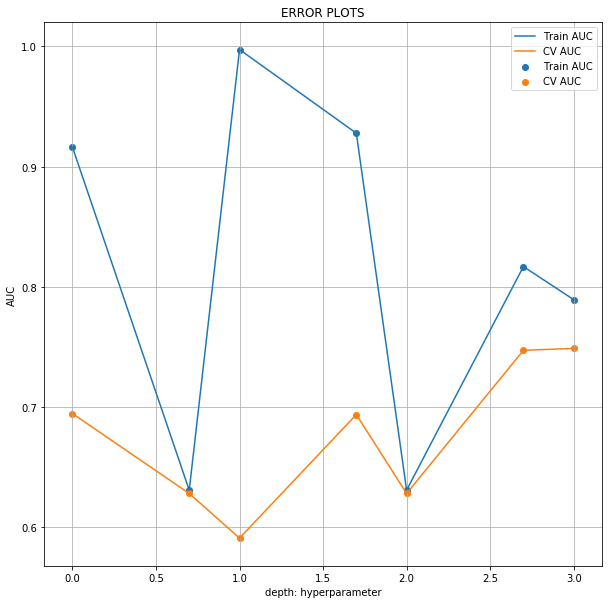

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
model6=DecisionTreeClassifier(class_weight='balanced')
parameters={'max_depth' :[1, 5, 10, 50, 100, 500, 1000],
            'min_samples_split' :[5, 10, 100, 500]}
clf6=RandomizedSearchCV(model6,parameters,cv=5,scoring='roc_auc',return_train_score=True)
best_clf6=clf6.fit(tfidf_sent_vectors_train,y_train)

train_auc= clf6.cv_results_['mean_train_score']
train_auc_std= clf6.cv_results_['std_train_score']
cv_auc = clf6.cv_results_['mean_test_score'] 
cv_auc_std= clf6.cv_results_['std_test_score']

K=np.log10([1, 5, 10, 50, 100, 500, 1000])
plt.plot(K, train_auc[:7], label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.scatter(K,train_auc[:7],label='Train AUC')

plt.plot(K, cv_auc[:7], label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
#plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.scatter(K,cv_auc[:7],label='CV AUC')
plt.legend()
plt.xlabel("depth: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

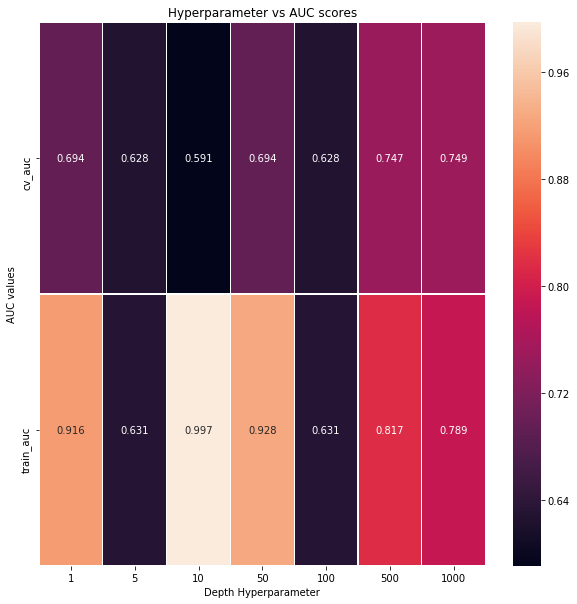

In [91]:
frame=pd.DataFrame(train_auc[:7],columns=['train_auc'])
frame['cv_auc']=cv_auc[:7]
frame['K']=[1, 5, 10, 50, 100, 500, 1000]
table=pd.pivot_table(frame,values=['train_auc','cv_auc'],columns=['K'])
import seaborn as sns
sns.heatmap(table, annot=True, fmt=".3f" ,linewidths=.2)
plt.title('Hyperparameter vs AUC scores')
plt.xlabel('Depth Hyperparameter')
plt.ylabel('AUC values')
plt.show()

In [92]:
bestC6=clf6.best_params_['max_depth']
bestreg6=clf6.best_params_['min_samples_split']
print(bestreg6)
print(bestC6)

5
5


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.750278984703412


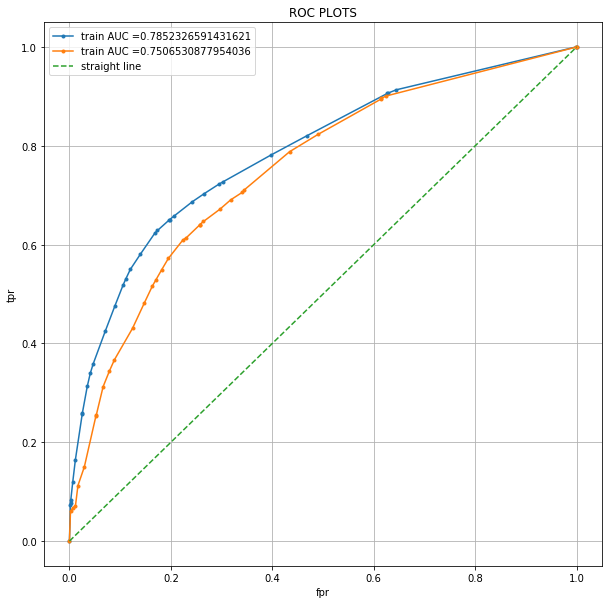

In [93]:
from sklearn.tree import DecisionTreeClassifier
model6s = DecisionTreeClassifier(max_depth=bestC6,min_samples_split=bestreg6,class_weight='balanced')
model6s.fit(tfidf_sent_vectors_train, y_train)
y_trn_pred=model6s.predict(tfidf_sent_vectors_train)
y_tst_pred=model6s.predict(tfidf_sent_vectors_test)
print(clf6.best_estimator_)
print(clf6.score(tfidf_sent_vectors_test, y_test))

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, threshold = roc_curve(y_train, model6s.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model6s.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr,marker='.',label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,marker='.',label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0, 1], [0, 1], linestyle='--',label='straight line')
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC PLOTS")
plt.rcParams['figure.figsize']=(10,10)
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr): 0.5221239252788452 ------> for Threshold: 0.456
confusion matrix using train data:
[[ 2191   460]
 [ 6816 11533]]


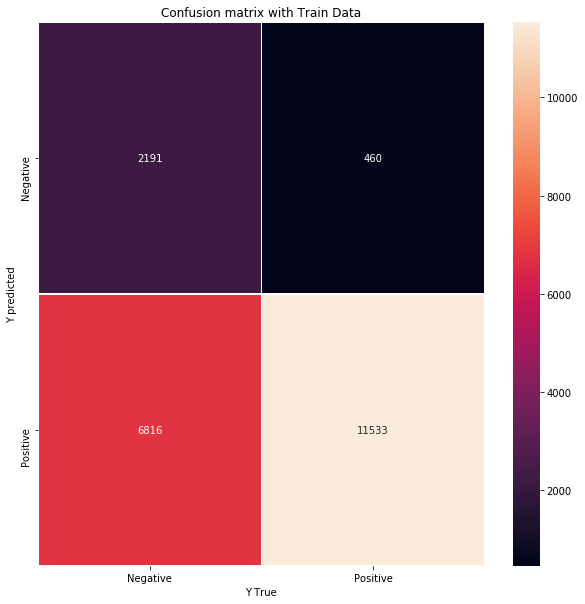

In [94]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(threshold, train_fpr, train_tpr)
print('confusion matrix using train data:')
print(confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t)))

q=confusion_matrix(y_train,predict_with_best_t(y_trn_pred, best_t))
import seaborn as sns
sns.heatmap(q, annot=True, fmt="d" ,linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion matrix with Train Data')
plt.xlabel('Y True')
plt.ylabel('Y predicted')
plt.show()

confusion matrix using test data:
[[1101  330]
 [2921 4648]]


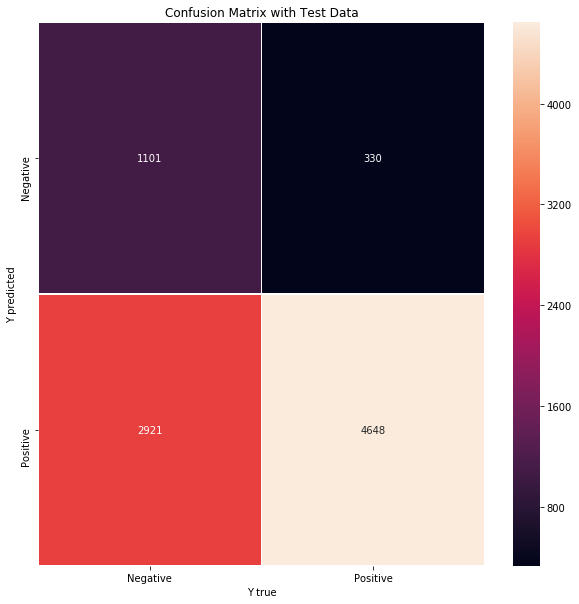

In [95]:
print('confusion matrix using test data:')
print(confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t)))
w=confusion_matrix(y_test,predict_with_best_t(y_tst_pred, best_t))
import seaborn as sns
sns.heatmap(w, annot=True, fmt="d",linewidths=.5,xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix with Test Data')
plt.xlabel('Y true')
plt.ylabel('Y predicted')
plt.show()

# [6] Conclusions

In [96]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['vectorizer','depth Hyperparameter','AUC']
x.add_row(['BOW',50,0.899])
x.add_row(['Feature engineering BOW',1000,0.934])
x.add_row(['TFIDF',10,0.806])
x.add_row(['AVG_W2V',500,0.848])
x.add_row(['TFIDF_W2V',500,0.828])


print(x)

+-------------------------+----------------------+-------+
|        vectorizer       | depth Hyperparameter |  AUC  |
+-------------------------+----------------------+-------+
|           BOW           |          50          | 0.899 |
| Feature engineering BOW |         1000         | 0.934 |
|          TFIDF          |          10          | 0.806 |
|         AVG_W2V         |         500          | 0.848 |
|        TFIDF_W2V        |         500          | 0.828 |
+-------------------------+----------------------+-------+
